# Part 1: Setup & Cleaning

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import pickle

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from IPython.core.display import display, HTML
sns.set()
%matplotlib inline

# Sklearn-preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.utils import class_weight
from category_encoders import TargetEncoder


# Machine Learning Algorithms
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, IsolationForest,
                              RandomForestRegressor, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier)
from sklearn.linear_model import Perceptron


# Performance metrics
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, make_scorer, balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
planets = pd.read_csv('data/exoplanets.csv', index_col='rowid')
planets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4183 entries, 1 to 4183
Columns: 355 entries, pl_hostname to st_colorn
dtypes: float64(306), int64(25), object(24)
memory usage: 11.4+ MB


In [3]:
planets.head()

,pl_hostname,pl_letter,pl_name,pl_discmethod,pl_controvflag,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,...,st_bmy,st_bmyerr,st_bmylim,st_m1,st_m1err,st_m1lim,st_c1,st_c1err,st_c1lim,st_colorn
rowid,,,,,,,,,,,,,,,,,,,,,
1,11 Com,b,11 Com b,Radial Velocity,0,1,326.03000,0.32,-0.32,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
2,11 UMi,b,11 UMi b,Radial Velocity,0,1,516.21997,3.20,-3.20,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3,14 And,b,14 And b,Radial Velocity,0,1,185.84000,0.23,-0.23,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
4,14 Her,b,14 Her b,Radial Velocity,0,1,1773.40002,2.50,-2.50,0.0,...,0.537,0.001,0.0,0.366,0.002,0.0,0.438,0.006,0.0,9
5,16 Cyg B,b,16 Cyg B b,Radial Velocity,0,1,798.50000,1.00,-1.00,0.0,...,0.418,0.003,0.0,0.222,0.003,0.0,0.351,0.003,0.0,17


In [86]:
planets.isnull().sum()

pl_hostname          0
pl_letter            0
pl_name              0
pl_discmethod        0
pl_controvflag       0
                  ... 
st_m1lim          3805
st_c1             3805
st_c1err          3806
st_c1lim          3805
st_colorn            0
Length: 355, dtype: int64

### Representation of null values in the dataframes

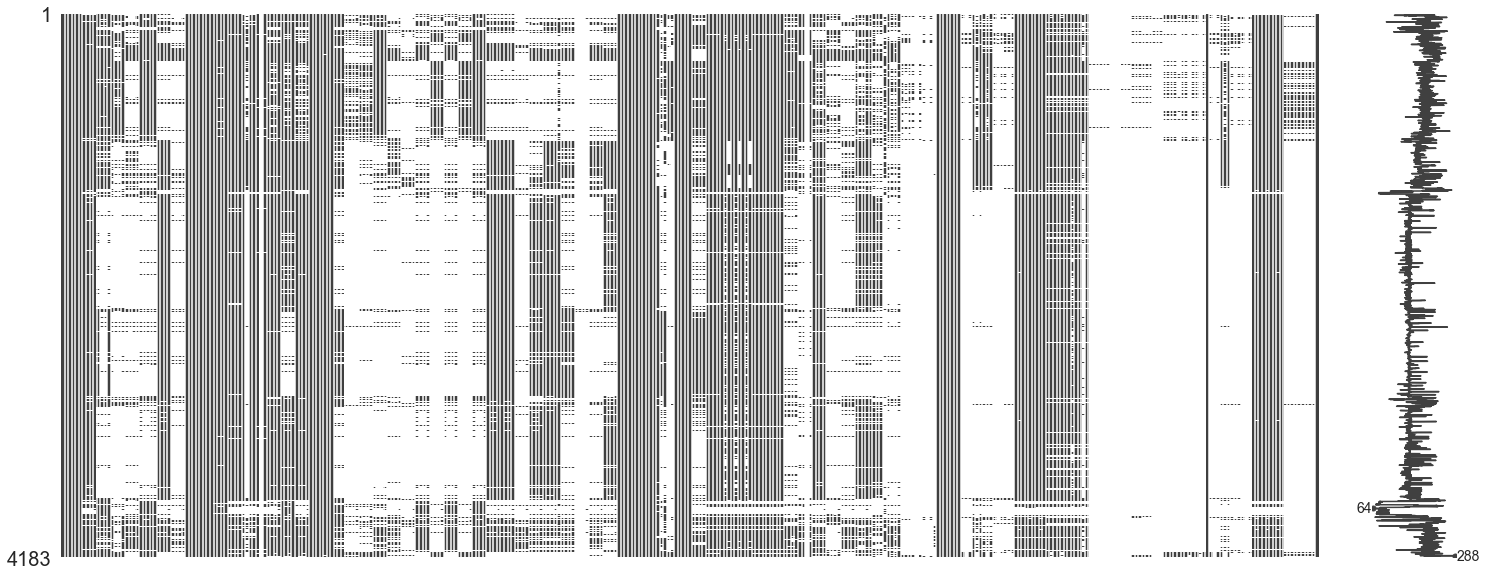

In [5]:
msno.matrix(planets)
# white indicates missing data

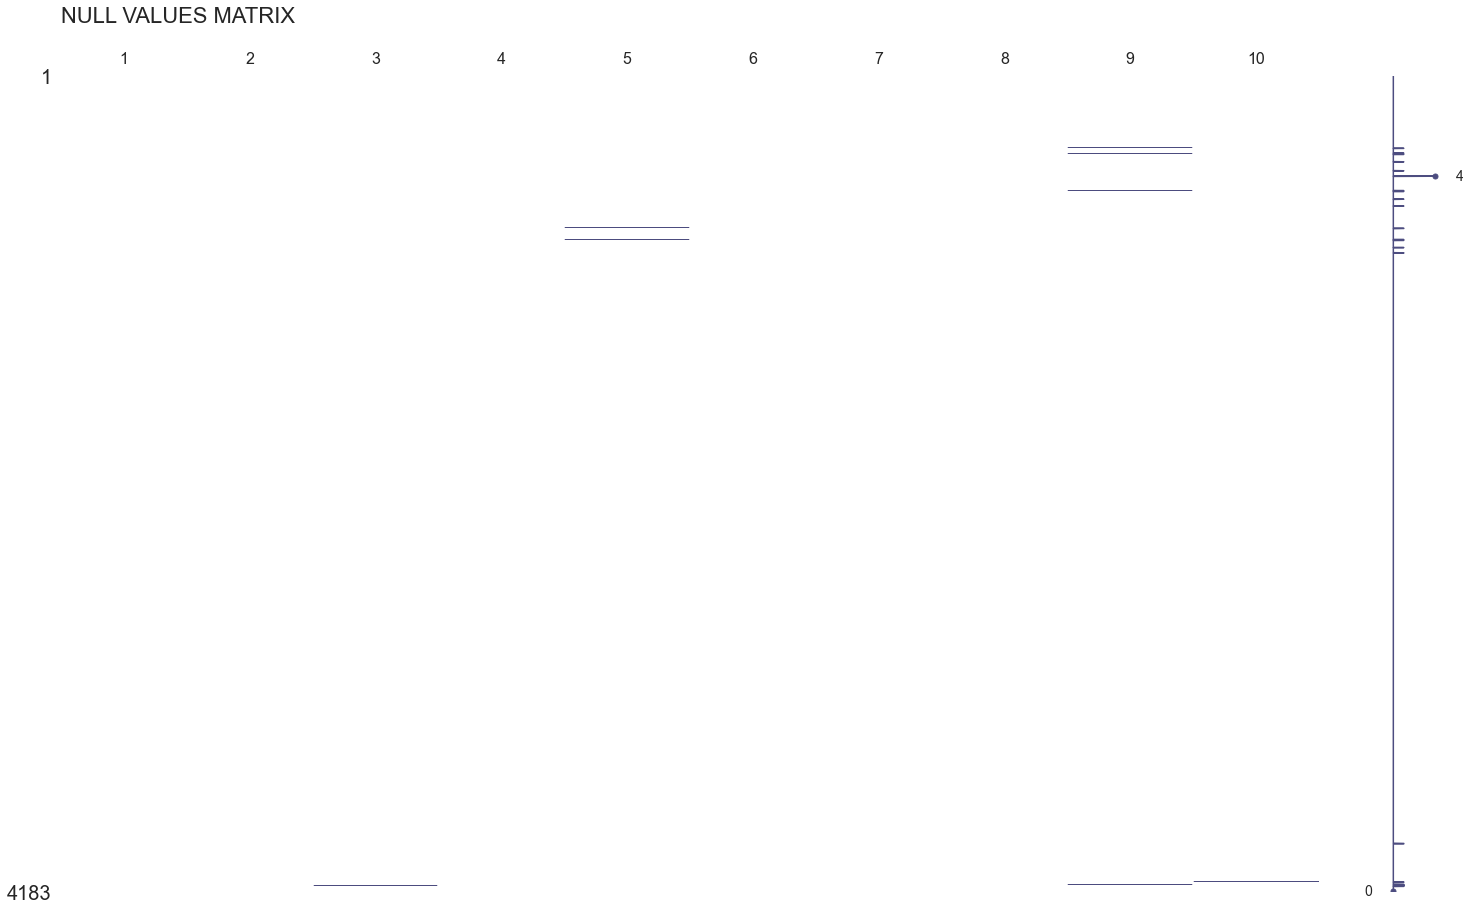

In [6]:
# defining matrix for the 10 columns with most nulls
mtrx = msno.matrix(planets, figsize=(25,15), filter='bottom',
               n=10, color=(0.3, 0.3, 0.5))
cols = [i.get_text() for i in mtrx.axes.get_xticklabels()]
ticks = np.arange(0, len(cols))

plt.xticks(ticks, labels=ticks+1, rotation=0, ha='center')
plt.title('Null Values Matrix\n'.upper(), loc='left', fontsize=22)
plt.show()

# empty string for the HTML and template for div
html_table = ''
template = '<div style="border-style:solid; display: inline-block; width: 325px; padding-left: 5px; border-width: thin" >{} - {}</div>'

table_order = [1, 5, 8,
               2, 6, 9,
               3, 7, 10,
               4]

for i in table_order:
    html_table += template.format(i, cols[i-1])

HTML(html_table)

## Data Preprocessing 

In [4]:
hec = pd.read_csv('data/phl_exoplanet_catalog.csv')
hec.info()
# this is the dataset that holds habitability column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4048 entries, 0 to 4047
Columns: 112 entries, P_NAME to P_SEMI_MAJOR_AXIS_EST
dtypes: float64(94), int64(4), object(14)
memory usage: 3.5+ MB


In [5]:
hec.head()

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,...,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,11 Com b,3.0,6165.86330,-476.74200,476.74200,NaN,NaN,NaN,2007,2014-05-14,...,0,Hot,0,0.083813,Coma Berenices,Com,Berenice's Hair,12.082709,6165.86330,1.29
1,11 UMi b,3.0,4684.78480,-794.57001,794.57001,NaN,NaN,NaN,2009,2018-09-06,...,0,Hot,0,0.082414,Ursa Minor,UMi,Little Bear,12.229641,4684.78480,1.53
2,14 And b,3.0,1525.57440,NaN,NaN,NaN,NaN,NaN,2008,2014-05-14,...,0,Hot,0,0.081917,Andromeda,And,Andromeda,12.848516,1525.57440,0.83
3,14 Her b,3.0,1481.07850,-47.67420,47.67420,NaN,NaN,NaN,2002,2018-09-06,...,0,Cold,0,0.145241,Hercules,Her,Hercules,12.865261,1481.07850,2.93
4,16 Cyg B b,3.0,565.73385,-25.42624,25.42624,NaN,NaN,NaN,1996,2018-09-06,...,1,Warm,0,0.368627,Cygnus,Cyg,Swan,13.421749,565.73385,1.66


In [6]:
target_count = hec['P_HABITABLE'].value_counts()
'''
0 --> not habitable
1 --> conservative
2 --> optimistic
'''
target_count

0    3993
2      34
1      21
Name: P_HABITABLE, dtype: int64

In [7]:
# drop not habitable planets
hec = hec[hec.P_HABITABLE != 0]

In [8]:
# create habitable column for planets data with the help of hec dataframe
# get names of planets
habitable_planets = hec.P_NAME.values
planets['habitable'] = planets['pl_name'].isin(habitable_planets)

In [9]:
target_count = planets['habitable'].value_counts()
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')
print(f'Percentage of Minority Class: {round(target_count[1] / sum(target_count), 4)*100}')

Class 0: 4129
Class 1: 54
Percentage of Majority Class: 98.71
Percentage of Minority Class: 1.29


So I have an imbalanced dataset, I will deal with it later.

### Handling Missing Data  

In [10]:
# remove columns with more than 40% missing data
def remove_missing(f):
    count = len(planets[planets[f].isnull()])
    if count/len(planets) > 0.4:
        return 1
    else:
        return 0
    
missing_values = [x for x in planets.columns if remove_missing(x)]
planets = planets.drop(missing_values, axis=1)

In [13]:
# IterativeImputer
# get only numeric values
numeric_values = planets[planets._get_numeric_data().columns]
imp = IterativeImputer(RandomForestRegressor(), max_iter=10, random_state=76)
numeric_values = pd.DataFrame(imp.fit_transform(numeric_values), columns=numeric_values.columns)
numeric_values.to_csv('Imputed Data.csv', index='rowid')

In [11]:
imputed_numerics = pd.read_csv('data/Imputed Data.csv')

In [12]:
# merge imputed data with the planets dataframe
for i in imputed_numerics.columns:
    if i not in planets.columns:
        pass
    else:
        planets[i] = imputed_numerics[i]

In [13]:
# remove categorical features with more than 10 unique values
cols = [x for x in planets.columns if x not in planets._get_numeric_data().columns]
for i in cols:
    if(len(planets[i].unique()) > 10):
        planets = planets.drop(i, axis=1)

In [14]:
# also drop these columns too since they are useless to modeling
cols_to_drop = ['pl_letter', 'pl_nnotes', 'pl_tsystemref', 'pl_disc', 
                'pl_locale', 'pl_status', 'st_nts', 'st_nplc', 'st_nglc', 
                'st_nrvc', 'st_naxa', 'st_nimg', 'st_nspec', 'st_photn', 
                'st_colorn']

planets = planets.drop(cols_to_drop, axis=1)

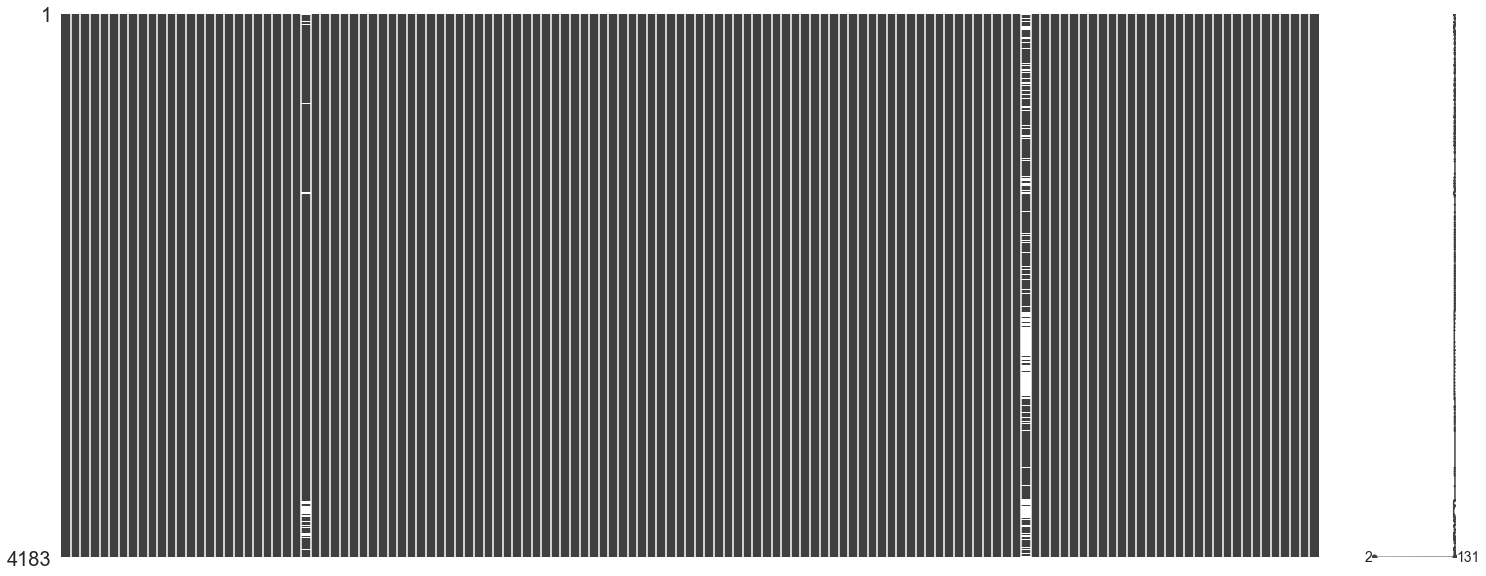

In [98]:
msno.matrix(planets)

### To Handle Remaining Missing Data 

In [15]:
# Unique value distribution of categorical features
cat_count = planets['st_optband'].value_counts()
cat_count1 = planets['st_metratio'].value_counts()
print(f'Optical Magnitude Bands:\n{cat_count}')
print('\n')
print(f'Metallicity Ratios:\n{cat_count1}')

Optical Magnitude Bands:
Kepler-band    2311
V (Johnson)    1661
Name: st_optband, dtype: int64


Metallicity Ratios:
[Fe/H]    2826
[M/H]       55
[m/H]       20
Name: st_metratio, dtype: int64


In [16]:
planets[['st_optband', 'st_metratio']].isnull().sum()

st_optband      211
st_metratio    1282
dtype: int64

In [17]:
# I fill categorical missing values with most common features because of the difference between their distributions
simp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
planets[['st_optband', 'st_metratio']] = simp.fit_transform(planets[['st_optband', 'st_metratio']])
planets.dropna(how='any', axis=0, inplace=True)

In [18]:
# Any missing values?
print(planets.isnull().values.any())

False


# Part 2: Visualization & EDA

In [58]:
planets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4182 entries, 1 to 4182
Columns: 131 entries, pl_controvflag to habitable
dtypes: float64(129), object(2)
memory usage: 4.2+ MB


In [59]:
planets.describe()

,pl_controvflag,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_radj,pl_radjerr1,pl_radjerr2,pl_radjlim,...,st_jmh2,st_jmh2err,st_jmh2lim,st_hmk2,st_hmk2err,st_hmk2lim,st_jmk2,st_jmk2err,st_jmk2lim,habitable
count,4182.000000,4182.000000,4.182000e+03,4.182000e+03,4.182000e+03,4182.000000,4182.000000,4182.000000,4182.000000,4182.000000,...,4182.000000,4182.000000,4182.000000,4182.000000,4182.000000,4182.000000,4182.000000,4182.000000,4182.000000,4182.000000
mean,0.004304,1.780488,2.845543e+03,2.093351e+03,-2.646173e+03,-0.000564,0.395080,0.057489,-0.050409,-0.002767,...,0.389317,0.053101,0.001655,0.085211,0.057743,-0.001136,0.478961,0.058852,0.003434,0.012912
std,0.065473,1.159849,1.140641e+05,5.973184e+04,6.529723e+04,0.038449,0.385986,0.147706,0.104310,0.038615,...,0.145233,0.149529,0.067118,0.105505,0.213851,0.079699,0.198866,0.254860,0.078980,0.112911
min,0.000000,1.000000,9.070629e-02,0.000000e+00,-3.650000e+06,-1.000000,0.030000,0.000000,-2.900000,-1.000000,...,-1.636000,0.017000,-1.000000,-0.906000,0.009000,-1.000000,-0.287000,0.010000,-1.000000,0.000000
25%,0.000000,1.000000,4.602943e+00,1.900000e-05,-3.887500e-03,0.000000,0.160000,0.018000,-0.042030,0.000000,...,0.292000,0.030000,0.000000,0.050000,0.030000,0.000000,0.348000,0.030000,0.000000,0.000000
50%,0.000000,1.000000,1.255604e+01,1.300000e-04,-1.300000e-04,0.000000,0.256000,0.045000,-0.035000,0.000000,...,0.360000,0.035000,0.000000,0.080000,0.036000,0.000000,0.432000,0.034000,0.000000,0.000000
75%,0.000000,2.000000,5.127680e+01,3.892500e-03,-1.900000e-05,0.000000,0.441347,0.057350,-0.014000,0.000000,...,0.477000,0.043000,0.000000,0.118000,0.049000,0.000000,0.580000,0.043428,0.000000,0.000000
max,1.000000,8.000000,7.300000e+06,3.650000e+06,0.000000e+00,1.000000,6.900000,6.148000,0.000000,1.000000,...,1.357000,8.888000,1.000000,2.165000,9.995000,1.000000,1.971000,9.995000,1.000000,1.000000


In [60]:
# most planet numbers in a stellar system
planets['pl_pnum'].nlargest(10)

rowid
1398    8.0
1399    8.0
1400    8.0
1401    8.0
1402    8.0
1403    8.0
1404    8.0
3610    8.0
3920    7.0
3921    7.0
Name: pl_pnum, dtype: float64

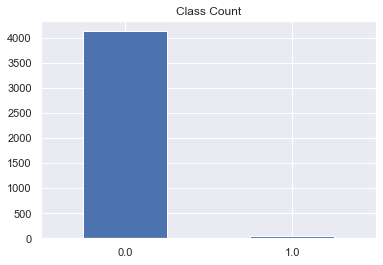

In [61]:
# target class's distribution
target_count = planets['habitable'].value_counts()
target_count.plot(kind='bar', title='Class Count', rot=0) 

Text(0.5, 1.0, 'Temperature - Mass Relation with Habitability')

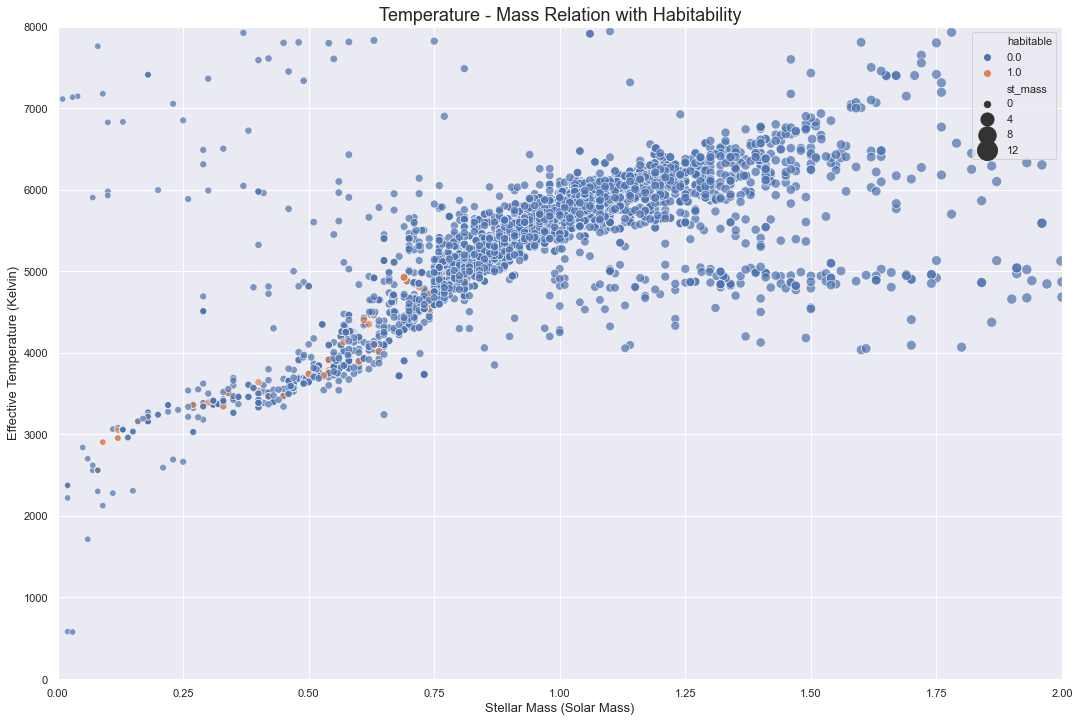

In [57]:
plt.figure(figsize=(18, 12))
ax = sns.scatterplot(x='st_mass', y='st_teff',
                     hue='habitable', size='st_mass',
                     sizes=(40, 400), alpha=.7,
                     data=planets)
# limiting x and y axis's values
ax.axis([0,2, 0, 8000])
ax.set_xlabel('Stellar Mass (Solar Mass)', fontsize=13)
ax.set_ylabel('Effective Temperature (Kelvin)', fontsize=13)
ax.set_title('Temperature - Mass Relation with Habitability', fontsize=18)

### Distribution of Planets via Dec & Ra


Text(0, 0.5, 'Dec [decimal degrees]')

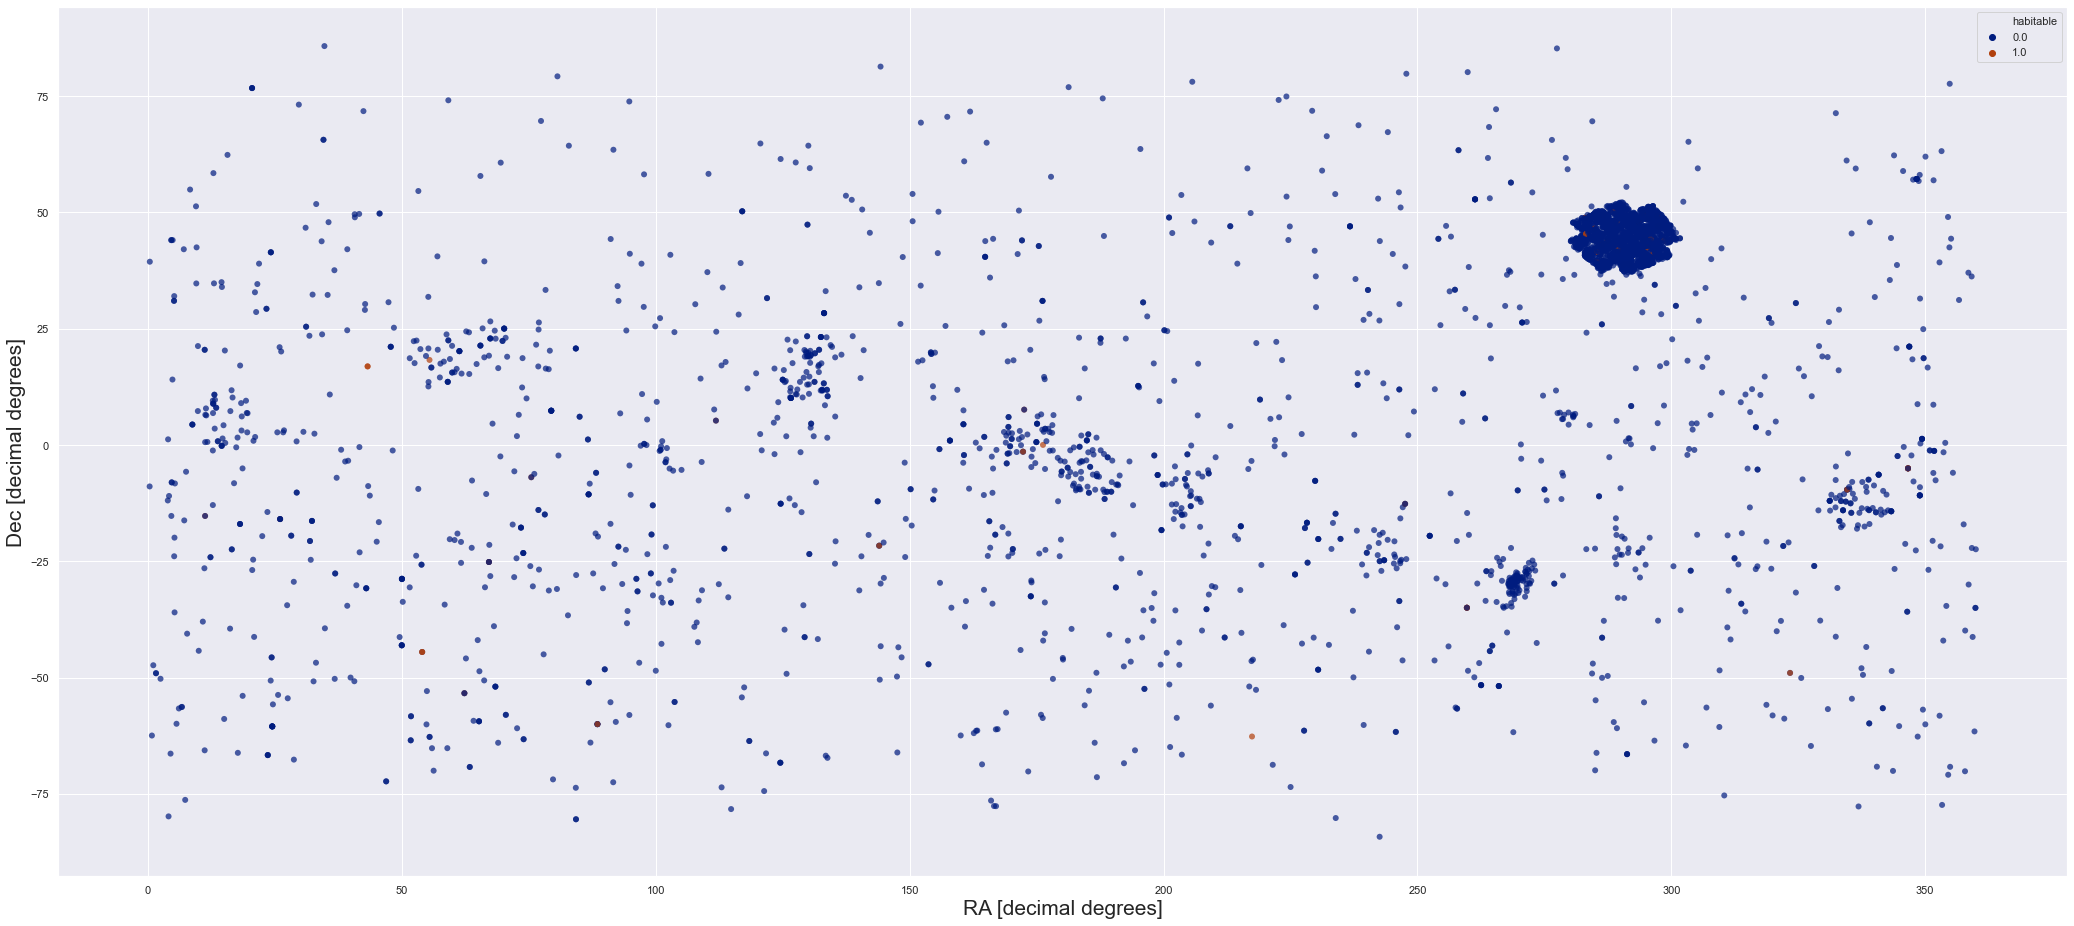

In [190]:
plt.figure(figsize=(36, 16))
sns.scatterplot(x="ra", y="dec",
                hue="habitable", alpha=.7,
                palette='dark', 
                sizes=(1, 8), linewidth=0,
                data=planets)
plt.xlabel('RA [decimal degrees]', fontsize=21)
plt.ylabel('Dec [decimal degrees]', fontsize=21)

### Visualization of Categorical Features

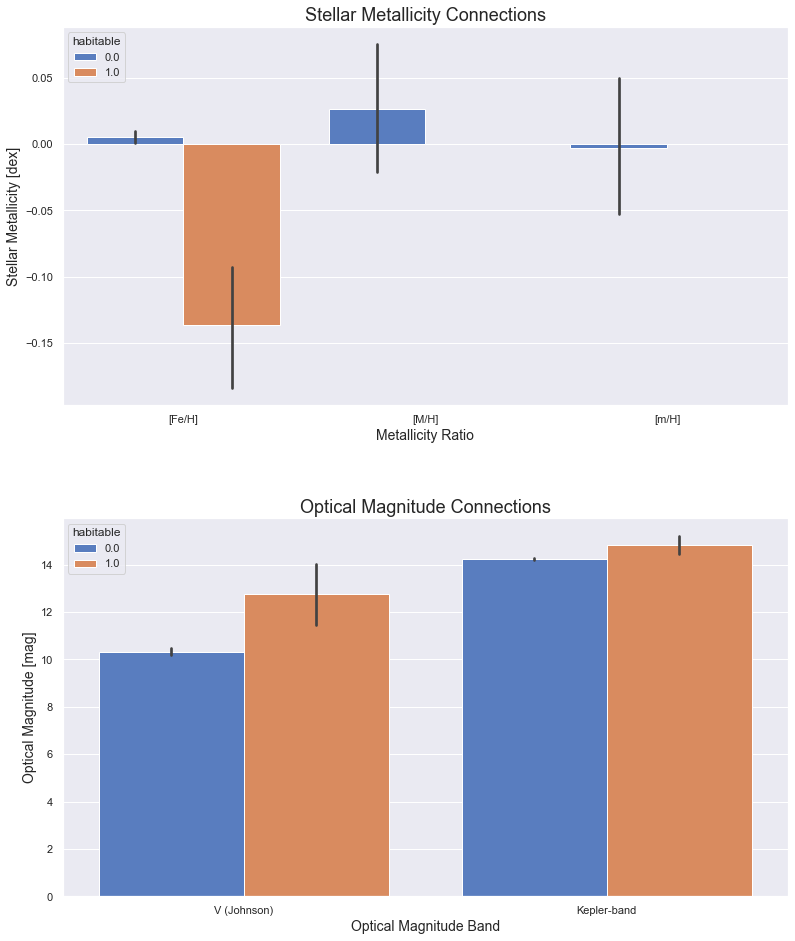

In [27]:
plt.figure(figsize=(13, 21))
plt.subplot(211)
m = sns.barplot(x="st_metratio", y="st_metfe", hue="habitable", data=planets,
                palette="muted")
plt.xlabel('Metallicity Ratio', fontsize=14)
plt.ylabel('Stellar Metallicity [dex]', fontsize=14)
plt.title('Stellar Metallicity Connections', fontsize=18)

plt.subplot(212)
o = sns.barplot(x="st_optband", y="st_optmag", hue="habitable", data=planets,
                palette="muted")
plt.xlabel('Optical Magnitude Band', fontsize=14)
plt.ylabel('Optical Magnitude [mag]', fontsize=14)
plt.title('Optical Magnitude Connections', fontsize=18)

plt.subplots_adjust(hspace = .3, top = .7)
plt.show()

### Pairplot with Most Correlated Features

In [19]:
corr_mtrx = planets.corr()
corr_df = pd.DataFrame(corr_mtrx['habitable'].sort_values(ascending=False))
corr_df.head(10)

,habitable
habitable,1.000000
gaia_plx,0.240225
gaia_pm,0.182810
st_pm,0.180979
st_jmk2,0.161823
pl_controvflag,0.154249
st_hmk2,0.133266
st_jmh2,0.128263
st_logg,0.102397
pl_pnum,0.098356


<Figure size 1080x504 with 0 Axes>

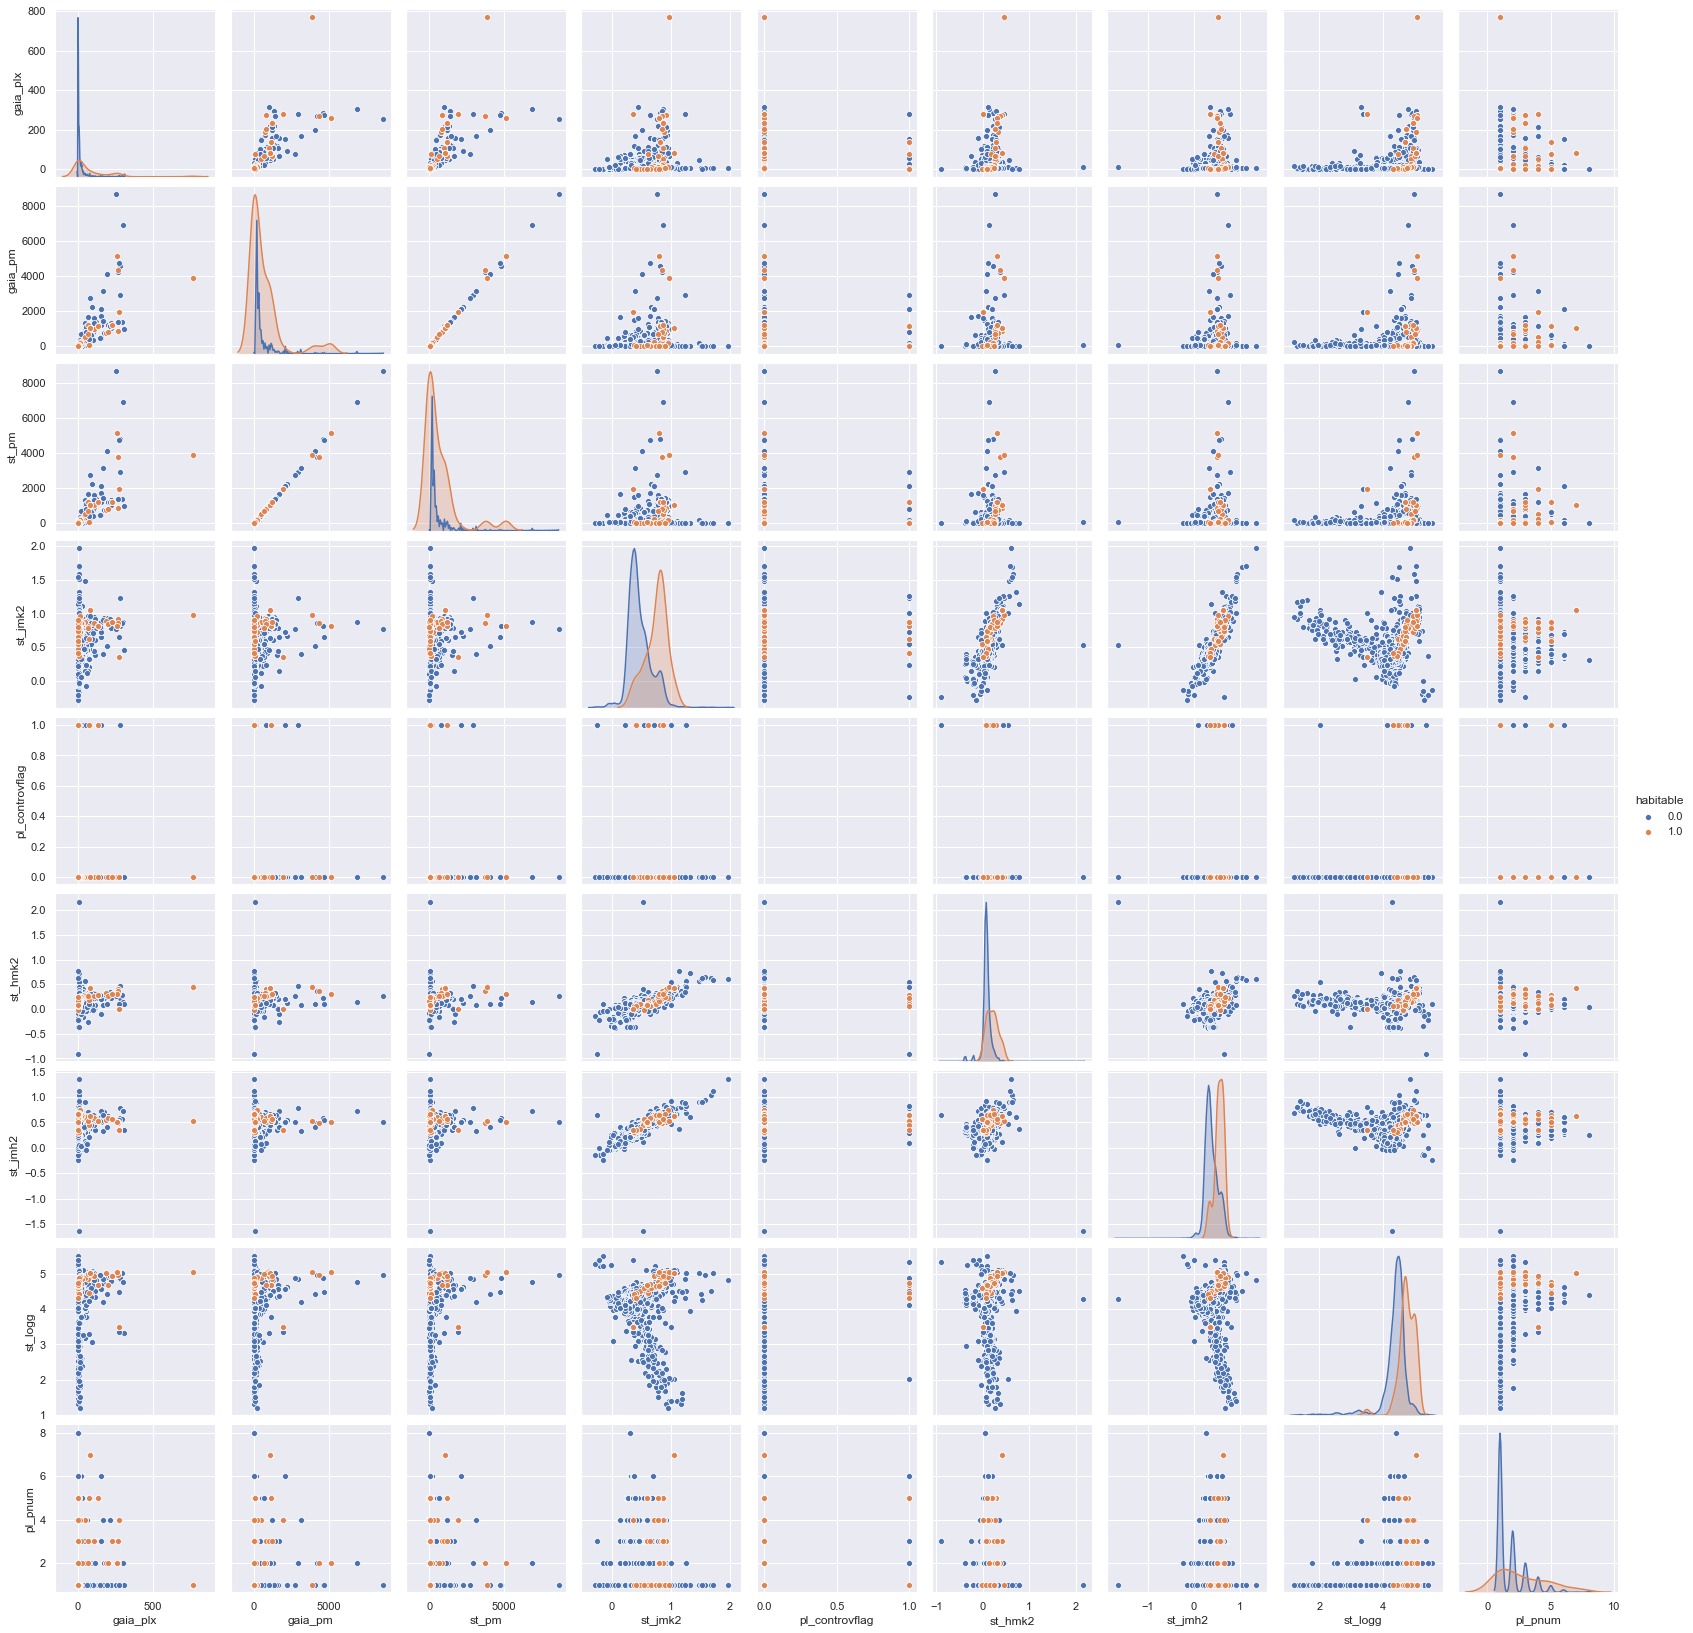

In [58]:
# Positive ones
plt.figure(figsize = (15,7))
sns.pairplot(planets[['habitable', 'gaia_plx', 'gaia_pm', 'st_pm', 'st_jmk2', 'pl_controvflag',
                 'st_hmk2', 'st_jmh2', 'st_logg', 'pl_pnum']], hue='habitable')

In [72]:
corr_df['habitable'].nsmallest(10)

gaia_pmdec   -0.163782
st_pmdec     -0.159427
st_mass      -0.116209
st_metfe     -0.103171
st_teff      -0.097191
st_dist      -0.054783
gaia_dist    -0.053475
st_glat      -0.045179
pl_radj      -0.045123
pl_rade      -0.045120
Name: habitable, dtype: float64

<Figure size 1080x504 with 0 Axes>

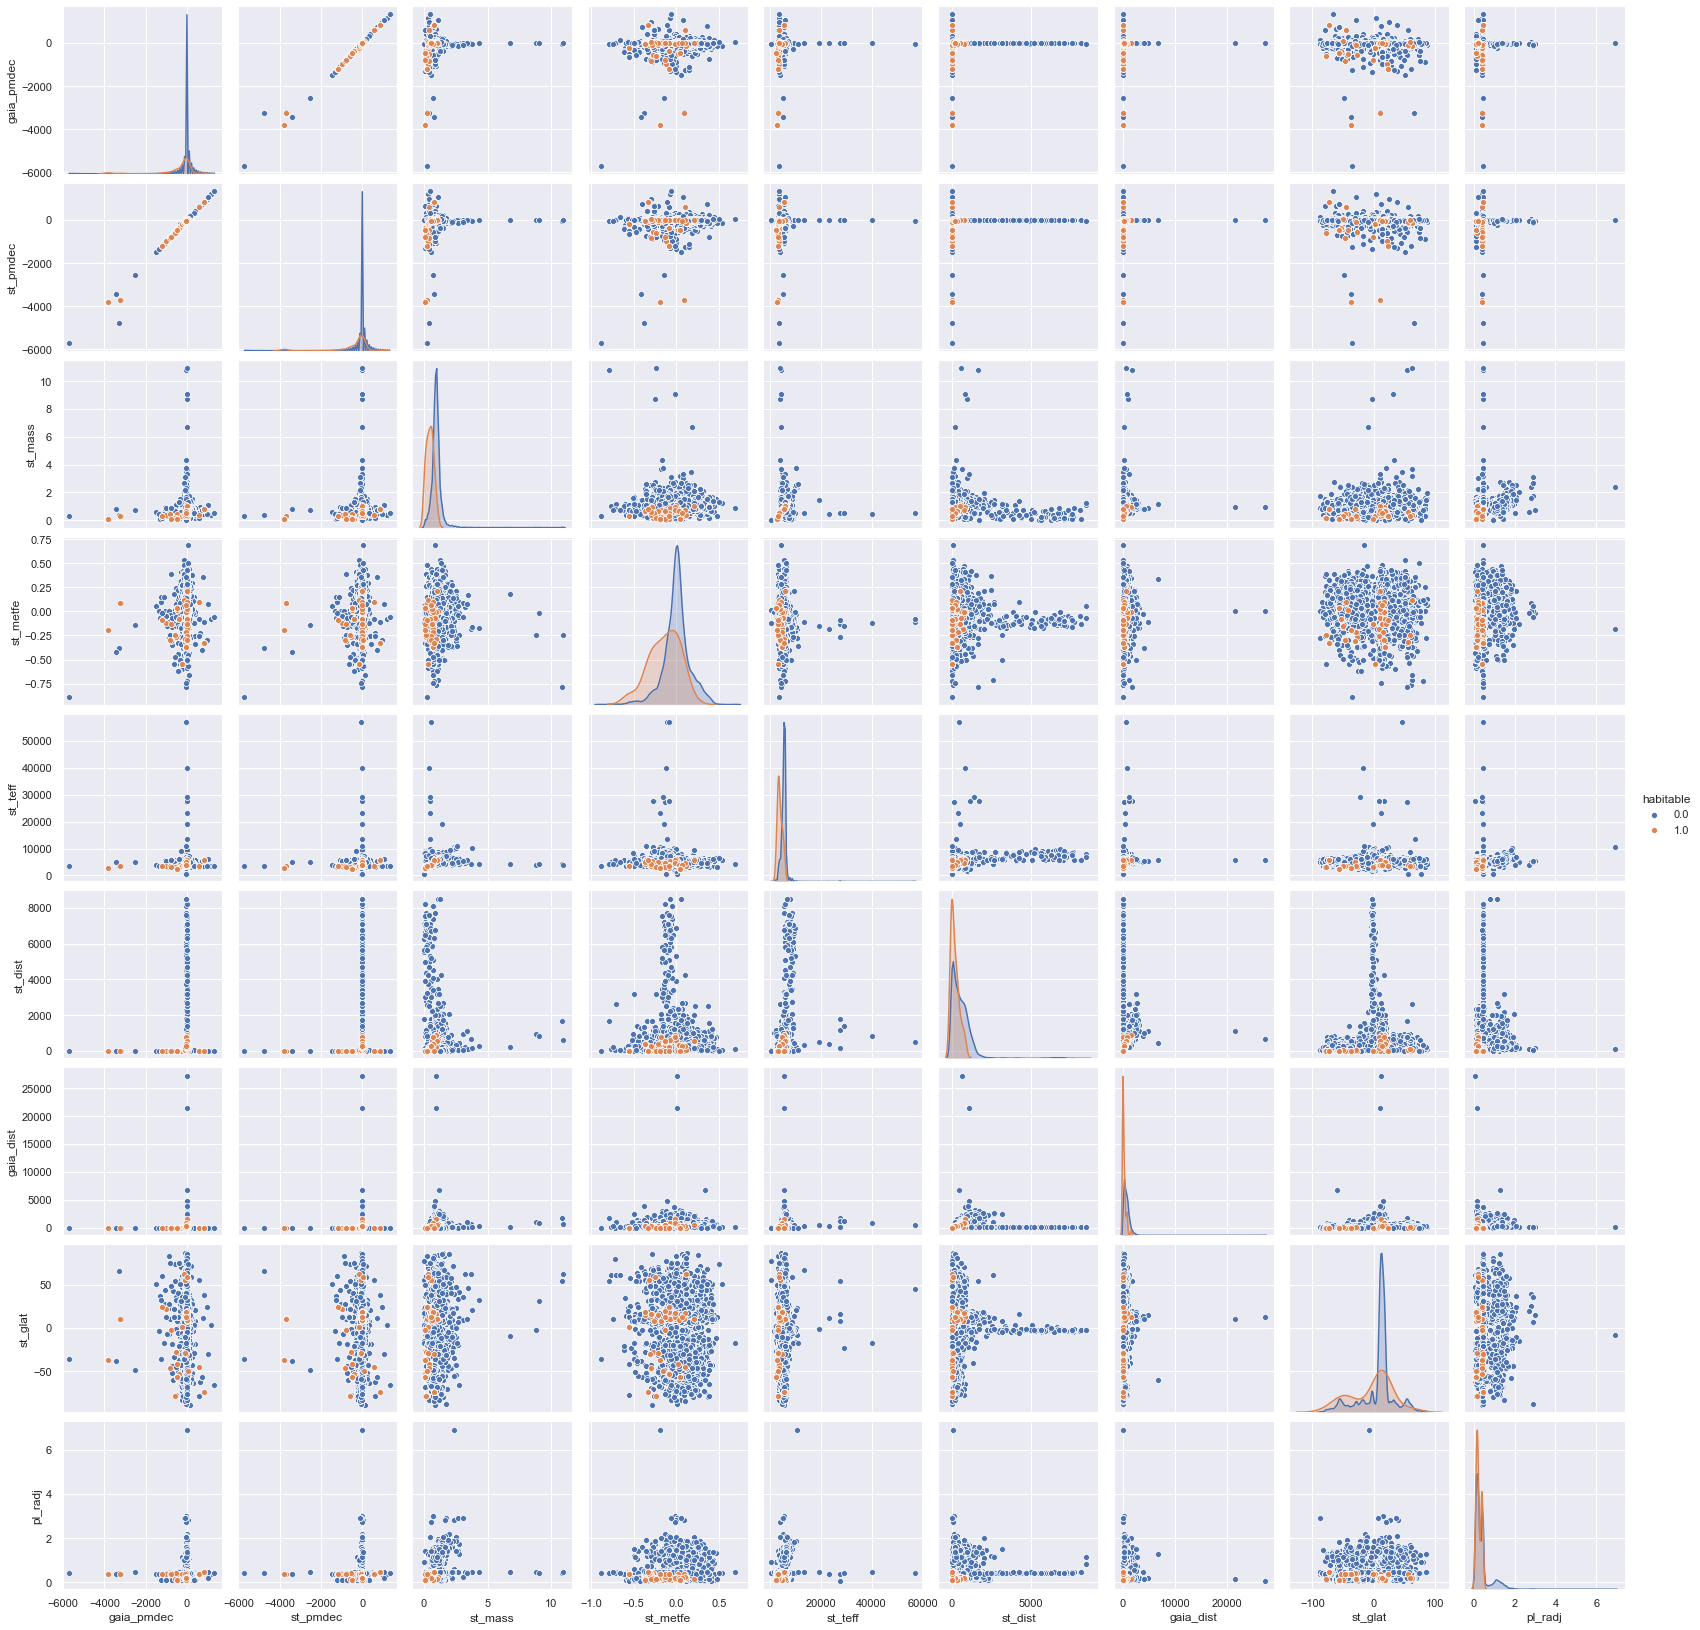

In [72]:
# Negative ones
plt.figure(figsize = (15,7))
sns.pairplot(planets[['habitable', 'gaia_pmdec', 'st_pmdec', 'st_mass', 'st_metfe', 'st_teff',
                 'st_dist', 'gaia_dist', 'st_glat', 'pl_radj']], hue='habitable')

### Distance - Travel Time

In [24]:
planets_c = planets[['st_dist', 'habitable', 'st_mass']]
planets_c.drop(planets_c[planets_c.habitable != 1].index, inplace=True)

In [25]:
planets_c['dist_to_star_ly'] = planets_c['st_dist'] * 3.26
"""
The Voyager 1 spacecraft is on an interstellar mission. It is traveling away from the Sun at a rate of 17.3 km/s. It means
62280 km/h. 
1 light year = 9.4605284 × 10^12 kilometers
1 year = 8760 hours
1 speed of light = 1079252848.8 km/h
""" 
planets_c['minimum_travel_time_year'] = (((planets_c['dist_to_star_ly'] * 9.461e12) / 62280) / 8760)
planets_c.head()

,st_dist,habitable,st_mass,dist_to_star_ly,minimum_travel_time_year
rowid,,,,,
142,3.67,1.0,0.12,11.9642,2.074761e+05
143,3.67,1.0,0.12,11.9642,2.074761e+05
156,15.14,1.0,0.40,49.3564,8.559094e+05
165,3.80,1.0,0.29,12.3880,2.148254e+05
177,20.20,1.0,0.42,65.8520,1.141966e+06


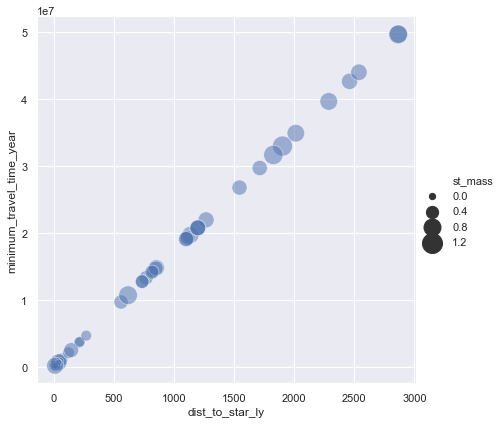

In [41]:
sns.relplot(x="dist_to_star_ly", y="minimum_travel_time_year", size="st_mass",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=planets_c)

# Part 3: Heading to Machine Learning

## 1. Data Preparation 

### Drop Lowly Correlated Features 

In [29]:
# corr_df had created in part-2
corr_df.tail(18)

,habitable
gaia_pmdec,-0.163782
st_distlim,NaN
gaia_distlim,NaN
st_optmaglim,NaN
gaia_gmaglim,NaN
st_masslim,NaN
st_radlim,NaN
pl_trandurlim,NaN
pl_tranmidlim,NaN
pl_mnum,NaN


These feature's correlation with habitability is "NaN" because each value of them are identical. That's why I got NaN as a correlation value.

In [46]:
planets_c = planets.copy()

In [47]:
cols_to_drop = ['st_distlim', 'gaia_distlim', 'st_optmaglim', 'gaia_gmaglim', 'st_masslim', 'st_radlim', 'pl_trandurlim', 
                'pl_tranmidlim', 'pl_mnum', 'gaia_plxlim', 'st_pmralim', 'st_pmdeclim', 'st_pmlim', 'gaia_pmralim', 
                'gaia_pmdeclim', 'gaia_pmlim', 'st_logglim', 'st_optband']
planets_c = planets_c.drop(cols_to_drop, axis=1)

In [28]:
# Insert categorical features into the planets_c 
# Remove the '[' character and the ']' character from column names as it causes issues during training
# planets_c.st_metratio = planets_c.st_metratio.map(lambda x: x.replace("]",""))
# planets_c.st_metratio = planets_c.st_metratio.map(lambda x: x.replace("[",""))

# Encoding categorical features
# cols_encode = ['st_metratio']
# enc = TargetEncoder()
# planets_c[cols_encode] = enc.fit_transform(planets_c[cols_encode], planets_c['habitable'])
# planets_c[['st_metratio']] = planets_c[cols_encode]

In [48]:
#Selecting highly correlated features
unrelevant_features = corr_df[corr_df['habitable'] <= 0.09]

to_drop = [column for column in unrelevant_features.index]
planets_c.drop(planets_c[to_drop[:97]], axis=1, inplace=True)

After some research, I decided to add these features to model's dataset: planet mass, planet's radial velocity amplitude [m/s], equilibrium temperature [K],planet radius [Earth radii], and orbital period [days]. But I have just planet radius and orbital period, there are so many missing data in the other features.

In [49]:
planets_c[['pl_rade', 'pl_orbper']] = planets[['pl_rade', 'pl_orbper']]

In [50]:
# Reorder columns
planets_c = planets_c[['pl_pnum', 'pl_controvflag', 'pl_rade', 'pl_orbper', 'st_teff',
                       'st_mass', 'st_pm', 'st_pmdec', 'st_metfe', 'st_logg', 'st_jmh2',
                       'st_jmk2', 'st_hmk2', 'gaia_plx', 'gaia_pm', 'gaia_pmdec', 'habitable']]
planets_c.describe()

,pl_pnum,pl_controvflag,pl_rade,pl_orbper,st_teff,st_mass,st_pm,st_pmdec,st_metfe,st_logg,st_jmh2,st_jmk2,st_hmk2,gaia_plx,gaia_pm,gaia_pmdec,habitable
count,4182.000000,4182.000000,4182.000000,4.182000e+03,4182.000000,4182.000000,4182.000000,4182.000000,4182.000000,4182.000000,4182.000000,4182.000000,4182.000000,4182.000000,4182.000000,4182.000000,4182.000000
mean,1.780488,0.004304,4.429392,2.845543e+03,5523.934671,0.983189,99.199005,-33.796086,0.003994,4.369585,0.389317,0.478961,0.085211,11.669355,99.263939,-33.625918,0.012912
std,1.159849,0.065473,4.333280,1.140641e+05,1822.507470,0.478622,367.406064,226.623742,0.155863,0.425876,0.145233,0.198866,0.105505,32.398873,369.851765,216.695089,0.112911
min,1.000000,0.000000,0.336000,9.070629e-02,575.000000,0.010000,0.200000,-5709.200000,-0.890000,1.200000,-1.636000,-0.287000,-0.906000,0.040000,0.200000,-5709.200000,0.000000
25%,1.000000,0.000000,1.782500,4.602943e+00,5013.072250,0.810000,8.100000,-20.000000,-0.070000,4.290000,0.292000,0.348000,0.050000,1.160000,7.800000,-20.100000,0.000000
50%,1.000000,0.000000,2.870000,1.255604e+01,5600.000000,0.960350,17.000000,-6.700000,0.009205,4.440000,0.360000,0.432000,0.080000,2.380000,16.800000,-7.100000,0.000000
75%,2.000000,0.000000,4.966600,5.127680e+01,5943.750000,1.117675,45.000000,2.700000,0.079422,4.560900,0.477000,0.580000,0.118000,9.210000,44.775000,1.717250,0.000000
max,8.000000,1.000000,77.342000,7.300000e+06,57000.000000,10.940000,8644.900000,1330.388000,0.690000,5.520000,1.357000,1.971000,2.165000,768.500000,8644.900000,1330.388000,1.000000


In [51]:
# log transformation to decrease the effect of the outliers
log_cols = ['gaia_plx', 'st_pm', 'gaia_pm', 'st_teff', 'pl_rade', 'pl_orbper']
planets_c[log_cols] = (planets_c[log_cols]+1).transform(np.log)

In [52]:
norm_cols = ['st_pmdec', 'gaia_pmdec']
planets_c[norm_cols] = preprocessing.normalize(planets_c[norm_cols])

In [53]:
planets_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4182 entries, 1 to 4182
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pl_pnum         4182 non-null   float64
 1   pl_controvflag  4182 non-null   float64
 2   pl_rade         4182 non-null   float64
 3   pl_orbper       4182 non-null   float64
 4   st_teff         4182 non-null   float64
 5   st_mass         4182 non-null   float64
 6   st_pm           4182 non-null   float64
 7   st_pmdec        4182 non-null   float64
 8   st_metfe        4182 non-null   float64
 9   st_logg         4182 non-null   float64
 10  st_jmh2         4182 non-null   float64
 11  st_jmk2         4182 non-null   float64
 12  st_hmk2         4182 non-null   float64
 13  gaia_plx        4182 non-null   float64
 14  gaia_pm         4182 non-null   float64
 15  gaia_pmdec      4182 non-null   float64
 16  habitable       4182 non-null   float64
dtypes: float64(17)
memory usage: 588.

### SMOTE - Over Sampling 

In [36]:
# Basic validation: splitting the data 60 - 20 - 20 train/val/test
X_train, X_test, y_train, y_test = train_test_split(planets_c.iloc[:, :-1], planets_c.loc[:, 'habitable'], test_size=0.25,random_state=76)
X_train.shape # shape of my train set

(3136, 17)

In [37]:
# Resampling imbalanced data
X_smoted, y_smoted = SMOTE(sampling_strategy='minority', random_state=76).fit_sample(X_train, y_train)

In [38]:
X_smoted.shape

(6196, 17)

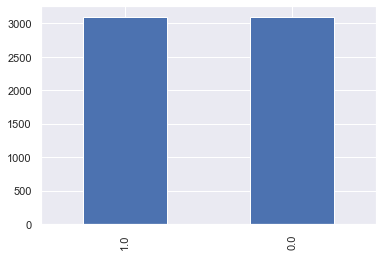

In [224]:
# observe that data has been balanced
pd.Series(y_smoted).value_counts().plot.bar()

In [284]:
# list to contain model and accuracy values
eva_list = []
# to contain model names
models = []

## 2. Machine Learning Models

### 2.1. Logistic Regression 

In [285]:
lr = LogisticRegression()
lr.fit(X_smoted, y_smoted)
y_pred_l = lr.predict(X_test)

lr_acc = round(lr.score(X_smoted, y_smoted) * 100, 2)
lr_acc_test = round(accuracy_score(y_test, y_pred_l) * 100, 2)
print(f'Train Accuracy of Logistic Regression: % {lr_acc}')
print(f'Test Accuracy of Logistic Regression: % {lr_acc_test}')

# Get precision, recall, and f1
precision, recall, f1, support = score(y_test, y_pred_l, average = 'macro')
print(f'Precision : {precision}')
print(f'Recall : {recall}')
print(f'F1-score : {f1}')

Train Accuracy of Logistic Regression: % 93.0
Test Accuracy of Logistic Regression: % 88.05
Precision : 0.5499947804999479
Recall : 0.8777912621359223
F1-score : 0.5592701581234178


In [286]:
# Add performance parameters to list
eva_list.append(dict([
    ('Model', 'Logistic Regression'),
    ('Train Accuracy', round(lr_acc, 2)),
    ('Test Accuracy', round(lr_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### 2.2. Linear SVC

In [287]:
svc = SVC(kernel='linear', gamma=0.001, C=100, probability=True)
svc.fit(X_smoted, y_smoted)
y_pred_s = svc.predict(X_test)

svc_acc = round(svc.score(X_smoted, y_smoted) * 100, 2)
svc_acc_test = round(accuracy_score(y_test, y_pred_s) * 100, 2)

print(f'Train Accuracy Score of LinearSVC: % {svc_acc}')
print(f'Test Accuracy Score of LinearSVC: % {svc_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred_s, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of LinearSVC: % 93.35
Test Accuracy Score of LinearSVC: % 88.53
Precision : 0.5588235294117647
Recall    : 0.941747572815534
F1-score   : 0.5743353228431904


In [288]:
eva_list.append(dict([
    ('Model', 'Linear SVC'),
    ('Train Accuracy', round(svc_acc, 2)),
    ('Test Accuracy', round(svc_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### 2.3. K-Nearest Neighbors 

In [289]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_smoted, y_smoted)
y_pred = knn.predict(X_test)

knn_acc = round(knn.score(X_smoted, y_smoted) * 100, 2)
knn_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)
print(f'Train Accuracy of KNN: % {knn_acc}')
print(f'Test Accuracy of KNN: % {knn_acc_test}')

# Get precision, recall, and f1
precision, recall, f1, support = score(y_test, y_pred, average = 'macro')
print(f'Precision : {precision}')
print(f'Recall : {recall}')
print(f'F1-score : {f1}')

Train Accuracy of KNN: % 99.13
Test Accuracy of KNN: % 96.18
Precision : 0.6106423516603157
Recall : 0.7959951456310679
F1-score : 0.6568241469816273


In [290]:
eva_list.append(dict([
    ('Model', 'K-Nearest Neighbors'),
    ('Train Accuracy', round(knn_acc, 2)),
    ('Test Accuracy', round(knn_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### 2.4. Naive Bayes

In [291]:
nbg = GaussianNB()
nbg.fit(X_smoted, y_smoted)
y_pred_n = nbg.predict(X_test)

nbg_acc=round(nbg.score(X_smoted, y_smoted) * 100, 2)
nbg_acc_test=round(accuracy_score(y_test, y_pred_n) * 100, 2)

print(f'Train Accuracy Score of GaussianNB: % {nbg_acc}')
print(f'Test Accuracy Score of GaussianNB: % {nbg_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred_n, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of GaussianNB: % 86.44
Test Accuracy Score of GaussianNB: % 88.05
Precision : 0.5429222014510537
Recall    : 0.8162621359223301
F1-score   : 0.5483701603070047


In [292]:
eva_list.append(dict([
    ('Model', 'Gaussian Naive Bayes'),
    ('Train Accuracy', round(nbg_acc, 2)),
    ('Test Accuracy', round(nbg_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### 2.5. Decision Trees 

In [43]:
dt = DecisionTreeClassifier()
dt.fit(X_smoted, y_smoted)
y_pred = dt.predict(X_test)

dt_acc = round(dt.score(X_smoted, y_smoted) * 100, 2)
dt_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)
print(f'Train Accuracy Score of Decision Trees: % {dt_acc}')
print(f'Test Accuracy Score of Decision Trees: % {dt_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of Decision Trees: % 100.0
Test Accuracy Score of Decision Trees: % 97.99
Precision : 0.6865737514518002
Recall    : 0.7436893203883495
F1-score   : 0.7111067271651214


In [296]:
eva_list.append(dict([
    ('Model', 'Decision Trees'),
    ('Train Accuracy', round(dt_acc, 2)),
    ('Test Accuracy', round(dt_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

In [44]:
# View feature importances
importances_dt = pd.DataFrame({'feature': X_train.columns,
                             'importance': dt.feature_importances_})
importances_dt = importances_dt.sort_values('importance',ascending=False).set_index('feature')
importances_dt.head(16)

,importance
feature,
st_logg,0.466552
pl_orbper,0.189261
pl_rade,0.174402
st_pm,0.075674
gaia_plx,0.033891
st_teff,0.022148
st_mass,0.011162
st_jmk2,0.008628
st_hmk2,0.006643


### 2.6. Random Forest 

In [300]:
num_estimator = 100
seed = 7
rf = RandomForestClassifier(n_estimators=num_estimator)
rf.fit(X_smoted, y_smoted)
y_predr = rf.predict(X_test)

rf_acc = round(rf.score(X_smoted, y_smoted) * 100, 2)
rf_acc_test = round(accuracy_score(y_test, y_predr) * 100, 2)
print(f'Train Accuracy Score of Random Forest: % {rf_acc}')
print(f'Test Accuracy Score of Random Forest: % {rf_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_predr, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of Random Forest: % 100.0
Test Accuracy Score of Random Forest: % 98.28
Precision : 0.7183311716385646
Recall    : 0.7451456310679612
F1-score   : 0.7309209398044932


In [301]:
eva_list.append(dict([
    ('Model', 'Random Forest'),
    ('Train Accuracy', round(rf_acc, 2)),
    ('Test Accuracy', round(rf_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

In [302]:
# View feature importances
importances_rf = pd.DataFrame({'feature': X_train.columns,
                             'importance': rf.feature_importances_})
importances_rf = importances_rf.sort_values('importance',ascending=False).set_index('feature')
importances_rf.head(16)

,importance
feature,
pl_orbper,0.187132
st_logg,0.172084
st_teff,0.094833
pl_rade,0.087880
st_jmh2,0.084987
st_jmk2,0.074426
st_mass,0.071308
st_pm,0.033617
st_hmk2,0.032548


### 2.7. Stochastic Gradient Boosting Classifier 

In [303]:
gbc = GradientBoostingClassifier(n_estimators=num_estimator, learning_rate=0.01,
                                random_state=seed)
gbc.fit(X_smoted, y_smoted)
y_pred_g = gbc.predict(X_test)

gbc_acc = round(gbc.score(X_smoted, y_smoted) * 100, 2)
gbc_acc_test = round(accuracy_score(y_test, y_pred_g) * 100, 2)
print(f'Train Accuracy Score of Gradient Boosting: % {gbc_acc}')
print(f'Test Accuracy Score of Gradient Boosting: % {gbc_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred_g, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of Gradient Boosting: % 98.11
Test Accuracy Score of Gradient Boosting: % 95.7
Precision : 0.6111934484789755
Recall    : 0.8550970873786408
F1-score   : 0.6627909475810785


In [304]:
eva_list.append(dict([
    ('Model', 'Stochastic Gradient Boosting Classifier'),
    ('Train Accuracy', round(gbc_acc, 2)),
    ('Test Accuracy', round(gbc_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### 2.8. AdaBoost Classifier 

In [305]:
abc = AdaBoostClassifier(base_estimator=rf, n_estimators=num_estimator, random_state = seed)
abc.fit(X_smoted, y_smoted)
y_pred = abc.predict(X_test)

abc_acc = round(abc.score(X_smoted, y_smoted) *100 , 2)
abc_acc_test = round(accuracy_score(y_test, y_pred) * 100 ,2)

print(f'Train Accuracy Score of AdaBoostClassifier: % {abc_acc}')
print(f'Test Accuracy Score of AdaBoostClassifier: % {abc_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1score, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1score}')

Train Accuracy Score of AdaBoostClassifier: % 100.0
Test Accuracy Score of AdaBoostClassifier: % 98.18
Precision : 0.7015091750986109
Recall    : 0.7138956310679612
F1-score   : 0.7075073218832325


In [306]:
eva_list.append(dict([
    ('Model', 'AdaBoost Classifier'),
    ('Train Accuracy', round(abc_acc, 2)),
    ('Test Accuracy', round(abc_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1score, 2))
     ]))

### 2.9. Voting Algorithms 

In [307]:
# Hard Voting
vc_hard = VotingClassifier(
    estimators=[('lr', lr), ('nb',nbg), ('rf', rf), ('gbc', gbc)],
    voting = 'hard')

vc_hard.fit(X_smoted, y_smoted)
y_pred = vc_hard.predict(X_test)

vch_acc = round(vc_hard.score(X_smoted, y_smoted) * 100, 2)
vch_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)

print(f'Train Accuracy Score of Hard VotingClassifier: % {vch_acc}')
print(f'Test Accuracy Score of Hard VotingClassifier: % {vch_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1score, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1score}')

Train Accuracy Score of Hard VotingClassifier: % 97.66
Test Accuracy Score of Hard VotingClassifier: % 96.37
Precision : 0.6012949039264829
Recall    : 0.7354368932038835
F1-score   : 0.638825282593683


In [308]:
eva_list.append(dict([
    ('Model', 'Hard Voting'),
    ('Train Accuracy', round(vch_acc, 2)),
    ('Test Accuracy', round(vch_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1score, 2))
     ]))

### 2.10. XGBoost

In [309]:
xgboost = xgb.XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)

xgboost.fit(X_smoted, y_smoted)
y_predx = xgboost.predict(X_test)

xg_acc = round(xgboost.score(X_smoted, y_smoted) * 100, 2)
xg_acc_test = round(accuracy_score(y_test, y_predx) * 100, 2)

print(f'Train Accuracy Score of Hard VotingClassifier: % {xg_acc}')
print(f'Test Accuracy Score of Hard VotingClassifier: % {xg_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1score, support = score(y_test, y_predx, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1score}')

[16:38:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Train Accuracy Score of Hard VotingClassifier: % 99.45
Test Accuracy Score of Hard VotingClassifier: % 97.9
Precision : 0.7078382838283829
Recall    : 0.9585558252427184
F1-score   : 0.7830693815987932


In [310]:
eva_list.append(dict([
    ('Model', 'XGBoost'),
    ('Train Accuracy', round(xg_acc, 2)),
    ('Test Accuracy', round(xg_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1score, 2))
     ]))

## 3. Evaluation

### Performance list of models

In [311]:
results = pd.DataFrame(data=eva_list)
results = results[['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
results = results.sort_values(by='Recall', ascending=False)
results = results.set_index('Model')
results

,Train Accuracy,Test Accuracy,Precision,Recall,F1
Model,,,,,
XGBoost,99.45,97.90,0.71,0.96,0.78
Linear SVC,93.35,88.53,0.56,0.94,0.57
Logistic Regression,93.00,88.05,0.55,0.88,0.56
Stochastic Gradient Boosting Classifier,98.11,95.70,0.61,0.86,0.66
Gaussian Naive Bayes,86.44,88.05,0.54,0.82,0.55
K-Nearest Neighbors,99.13,96.18,0.61,0.80,0.66
Random Forest,100.00,98.28,0.72,0.75,0.73
Hard Voting,97.66,96.37,0.60,0.74,0.64
Decision Trees,100.00,98.28,0.71,0.71,0.71


### Confusion Matrix 

In [312]:
conf_xg = confusion_matrix(y_test, y_predx)
conf_svc = confusion_matrix(y_test, y_pred_s)

def conf_matrix(x):
    plt.figure(dpi=125)
    sns.heatmap(x, cmap=plt.cm.Reds, annot=True, square=True,fmt='d',
               xticklabels=['not habitable', 'habitable'],
               yticklabels=['not habitable', 'habitable'])

    plt.xlabel('Predicted planets')
    plt.ylabel('Actual planets')

Text(0.5, 1.0, 'Confusion Matrix of XGBoost')

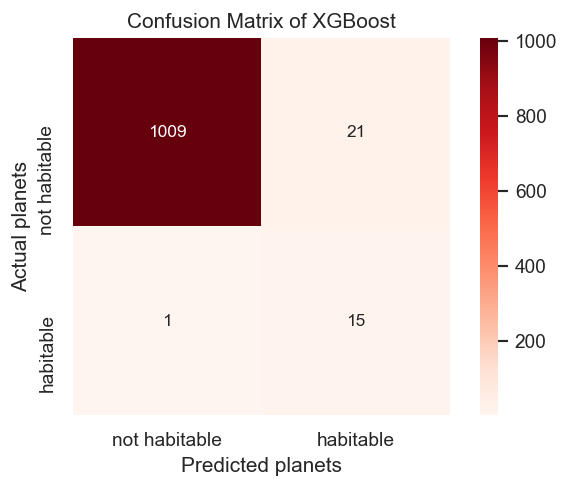

In [313]:
conf_matrix(conf_xg)
plt.title('Confusion Matrix of XGBoost')

Text(0.5, 1.0, 'Confusion Matrix of Linear SVC')

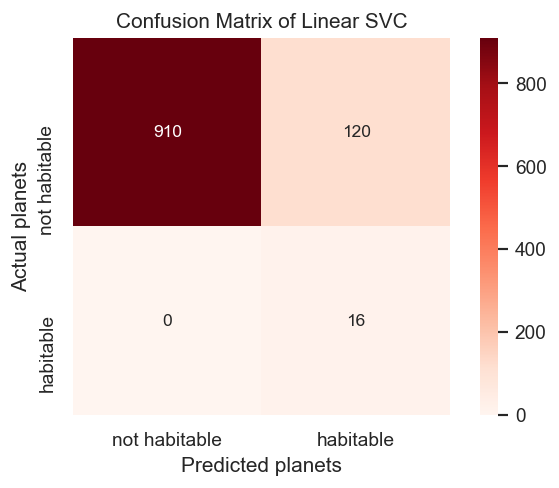

In [315]:
conf_matrix(conf_svc)
plt.title('Confusion Matrix of Linear SVC')

### Optimization of the Model 

#### XGBoost - GridSearchCV

In [316]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]}

In [317]:
kf=KFold(n_splits=10, shuffle=True, random_state=76)
xgb_grid = GridSearchCV(xgboost, param_grid=parameters, cv=kf, scoring='recall', n_jobs=-1)
xgb_grid.fit(X_smoted, y_smoted)

[16:50:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=KFold(n_splits=10, random_state=76, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.4, gamma=10, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.01, max_delta_step=0,
                                     max_depth=4, min_child_weight=1,
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=1000, n_jobs=0,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0.3, reg_lambda=1,
                                     scale_pos_weight=1, silent=False,
                                     subsample=0.8, tree_method='exact',
      

In [318]:
y_pred_x = xgb_grid.predict(X_test)

opt_xgb_test = round(accuracy_score(y_test, y_pred_x) * 100, 2)
print(f'Test Accuracy Score of Logistic Regression: % {opt_xgb_test}')

precision, recall, f1score, support = score(y_test, y_pred_x, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1score}')

Test Accuracy Score of Logistic Regression: % 97.61
Precision : 0.6881981089116866
Recall    : 0.9263349514563106
F1-score   : 0.758020487290292


In [319]:
# examine the best model
print(xgb_grid.best_params_)
print(xgb_grid.best_estimator_)

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 60}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=10, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=60, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, silent=False,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)


### Evaluation Graphs 

ROC AUC score =  0.9900485436893205


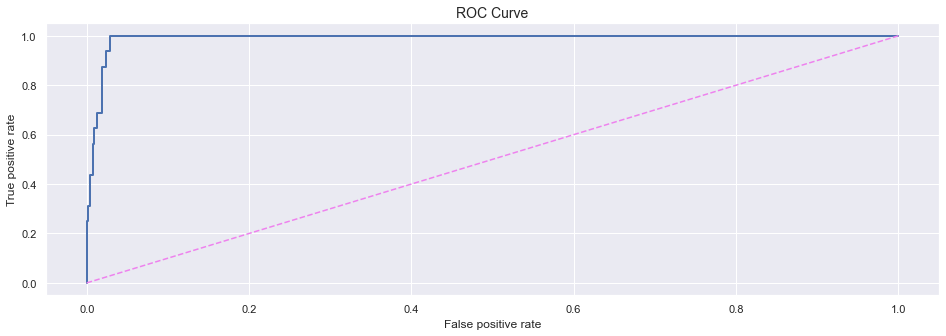

In [320]:
fpr, tpr, thresholds = roc_curve(y_test, xgb_grid.predict_proba(X_test)[:,1])

plt.figure(figsize = (16,5))
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve', fontsize=14)
print("ROC AUC score = ", roc_auc_score(y_test, xgb_grid.predict_proba(X_test)[:,1]))

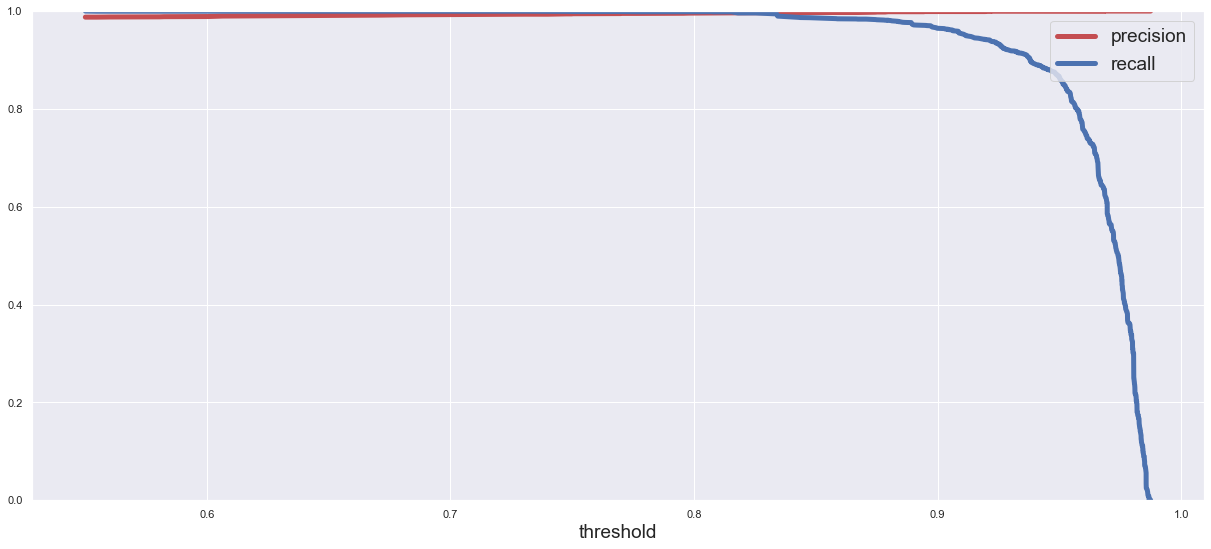

In [321]:
y_scores = xgb_grid.predict_proba(X_smoted)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_smoted, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])
    

plt.figure(figsize = (21, 9))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

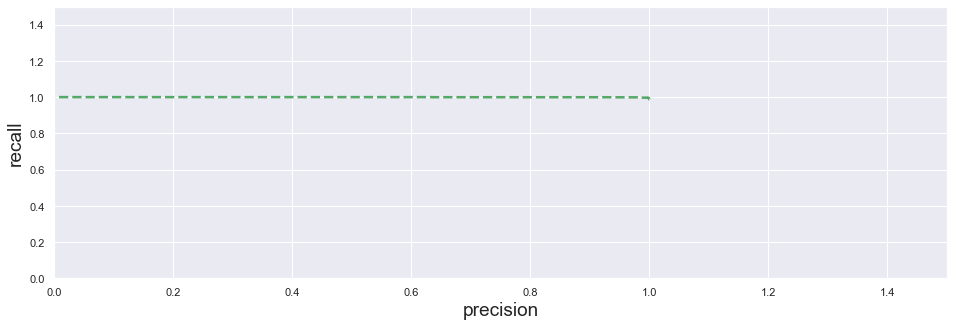

In [322]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, "g--", linewidth=2.5)
    plt.ylabel("recall", fontsize=19)
    plt.xlabel("precision", fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize = (16,5))
plot_precision_vs_recall(precision, recall)
plt.show()

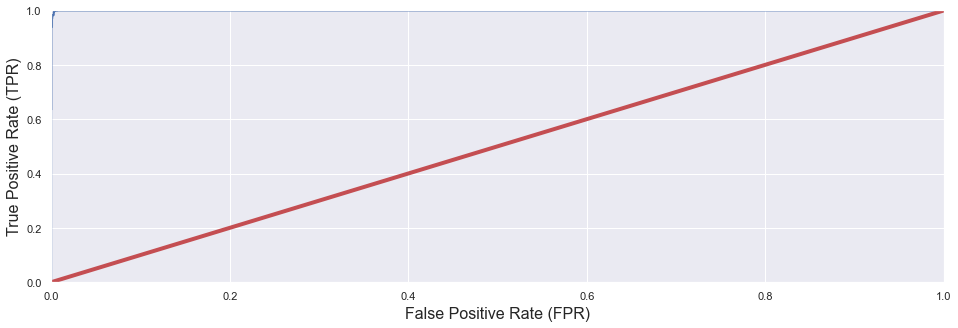

In [323]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_smoted, y_scores)
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize = (16,5))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

Text(0.5, 1.0, 'Precision and Recall Curves')

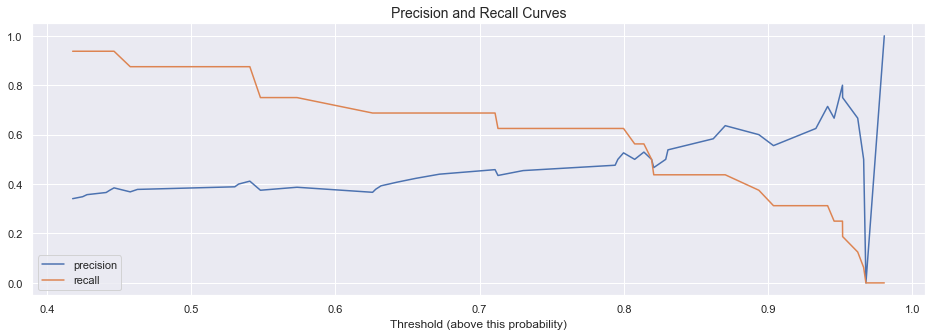

In [324]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, xgb_grid.predict_proba(X_test)[:,1] )

plt.figure(figsize = (16,5))
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability)')
plt.title('Precision and Recall Curves', fontsize=14)

In [325]:
# saving model
pickle.dump(xgb_grid, open("Flask/model.pkl","wb"))